In [1]:
import math
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
from os.path import isfile
from metpy.units import units
from datetime import datetime, timedelta

In [2]:
def getNewLatLon(lat, lon, bearing, distance):
    """
    Calcualtes a new lat, lon pair from bearing and distance
    """
    # Average radius of the earth
    earth_r = 6371 * units.km

    originLatInRadians = math.radians(lat)
    originLonInRadians = math.radians(lon)
    angularDistance = distance.to('km').magnitude / earth_r.magnitude
    bearingInRadians = math.radians(bearing)

    # Calculate new latitude
    new_lat = math.asin(math.sin(originLatInRadians) * math.cos(angularDistance) + math.cos(originLatInRadians) * 
                                 math.sin(angularDistance) * math.cos(bearingInRadians))

    # Calculate new longitude
    new_lon = originLonInRadians + math.atan2(math.sin(bearingInRadians) * math.sin(angularDistance) * 
                                                       math.cos(originLatInRadians), math.cos(angularDistance) - math.sin(originLatInRadians) * math.sin(new_lat))
    # Convert from radians to degrees
    new_lon = math.degrees(new_lon)
    new_lat = math.degrees(new_lat)

    return (new_lon, new_lat)

In [3]:
def distanceBetweenPoints(lat1, lon1, lat2, lon2, unit='km'):
    """
    Haversine formula to calculate the great-circle distance between two points
    """
    # Average radius of the earth
    earth_r = 6371 * units.km

    # Get lat lon pairs in radians
    lat1, lon1 = math.radians(lat1), math.radians(lon1)
    lat2, lon2 = math.radians(lat2), math.radians(lon2)

    # Get delta lat lon
    deltaLat = lat2-lat1
    deltaLon = lon2-lon1

    a = math.sin(deltaLat/2) * math.sin(deltaLat/2) + math.cos(lat1) * math.cos(lat2) * math.sin(deltaLon/2) * math.sin(deltaLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    return (earth_r * c).to(units(unit))

In [4]:
def build_local_db(db, local_lat, local_lon, max_d, syear=1950, eyear=datetime.now().year):
    """
    Generate a local database of severe reports from main SPC database
    """
    # Initilize local database
    db_local = pd.DataFrame(columns=db.columns)

    # Calculate extent
    n_extent = getNewLatLon(local_lat, local_lon, 360, max_d)[1]
    s_extent = getNewLatLon(local_lat, local_lon, 180, max_d)[1]
    e_extent = getNewLatLon(local_lat, local_lon, 90, max_d)[0]
    w_extent = getNewLatLon(local_lat, local_lon, 270, max_d)[0]
    
    # Subset database based on years
    db = db.loc[(db.yr >= syear) & (db.yr <=eyear)]
    
    # Subset database based on on extent box
    db = db.loc[(db.slat >= s_extent) & (db.slat <= n_extent) & (db.slon >= w_extent) & (db.slon <= e_extent)]
    
    # Get local LSRs within radius
    for index, lsr in db.iterrows():
        
        # Get distance of lat lon pair
        d = distanceBetweenPoints(local_lat, local_lon, lsr.slat, lsr.slon)

        # Check if within acceptable range
        if d <= max_distance:
            db_local = db_local.append(lsr)
            
    # Set data types
    db_local = db_local.astype({'yr': 'int32'})
    db_local = db_local.astype({'mo': 'int32'})
    db_local = db_local.astype({'dy': 'int32'})
    db_local = db_local.astype({'mag': 'float64'})
    
    # Convert time from CST (UTC-6) to UTC
    db_local.time = pd.to_datetime(db_local.time, format='%H:%M:%S')
    db_local.time = db_local.time + timedelta(hours=6)
    
    # Bin time based on hour
    db_local.time = db_local.time.dt.hour
    
    return db_local

In [5]:
def download_era5(analysisTime):
    """
    Download ERA5 reanalysis for a given data and time
    """
    # Build file path
    outpath = f'/home/pi/workspace/Local-Severe-Weather-Stats/data/era5/era5-reanalysis_{analysisTime:%Y%m%d_%H%M}.nc'
    
    # Check if file exists
    if isfile(outpath) == False:
    
        # Start CDS API client
        c = cdsapi.Client()

        # Make CDS API request for ERA5 reanalysis
        c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'geopotential', 'relative_humidity', 'temperature',
            'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '100', '125', '150',
            '175', '200', '225',
            '250', '300', '350',
            '400', '450', '500',
            '550', '600', '650',
            '700', '750', '775',
            '800', '825', '850',
            '875', '900', '925',
            '950', '975', '1000',
        ],
        'year': f'{analysisTime:%Y}',
        'month': f'{analysisTime:%m}',
        'day': f'{analysisTime:%d}',
        'time': f'{analysisTime:%H:%M}',
        'area': [80.24, -149.06, 15.28, -47.81],
    }, outpath)

In [6]:
def get_db_reanalysis(db):
    """
    Downloads ERA5 reanalysis dataset for each event in dataset
    """
    for year, month, day, hour in zip(db.yr, db.mo, db.dy, db.time):

        eventTime = datetime(year, month, day, hour)

        download_era5(eventTime)

In [7]:
latitude  = 35.14
longitude = -111.67
max_distance = 150 * units.km
syear = 1979
eyear = 2019

In [8]:
# Load Tornado LSR data
tor = pd.read_csv('/home/pi/workspace/Local-Severe-Weather-Stats/data/1950-2019_torn.csv')
tor = tor[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

# Load Hail LSR data
hail = pd.read_csv('/home/pi/workspace/Local-Severe-Weather-Stats/data/1955-2019_hail.csv')
hail = hail[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

# Load Wind LSR data
wind = pd.read_csv('/home/pi/workspace/Local-Severe-Weather-Stats/data/1955-2019_wind.csv')
wind = wind[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Get local Tornado LSR data
tor_local = build_local_db(tor, latitude, longitude, max_distance, syear, eyear)
tor_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,56.000000,56.000000,56.000000,56.000000
mean,7.910714,15.178571,15.071429,0.375000
std,2.314200,7.687315,7.617819,0.776062
min,1.000000,1.000000,0.000000,0.000000
25%,7.000000,7.500000,12.750000,0.000000
50%,9.000000,15.500000,18.500000,0.000000
75%,10.000000,21.250000,20.000000,0.000000
max,10.000000,31.000000,23.000000,3.000000


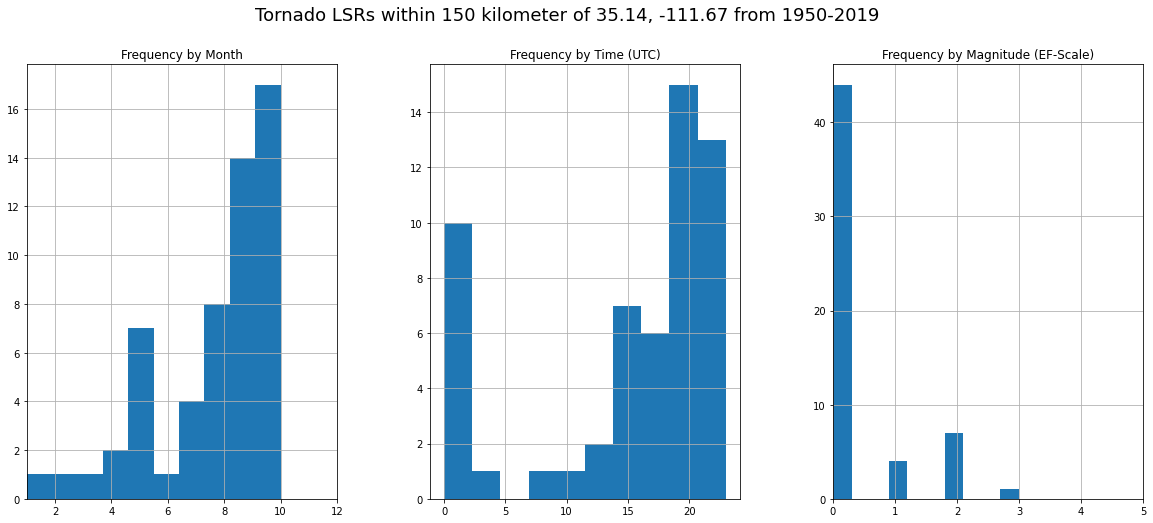

In [10]:
# Create plot for Tornado LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

tor_local.hist('mo', ax=ax0)
tor_local.hist('time', ax=ax1)
tor_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax2.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (EF-Scale)')
ax2.set_xlim(0, 5)

plt.suptitle(f'Tornado LSRs within {max_distance} of {latitude}, {longitude} from 1950-2019', size=18)

plt.show()

In [11]:
# Get local Hail LSR data
hail_local = build_local_db(hail, latitude, longitude, max_distance)
hail_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,365.000000,365.000000,365.000000,365.000000
mean,7.887671,14.843836,16.287671,1.090082
std,1.338765,8.482383,7.813203,0.456048
min,2.000000,1.000000,0.000000,0.750000
25%,7.000000,8.000000,15.000000,0.750000
50%,8.000000,14.000000,20.000000,1.000000
75%,9.000000,22.000000,21.000000,1.000000
max,10.000000,31.000000,23.000000,4.500000


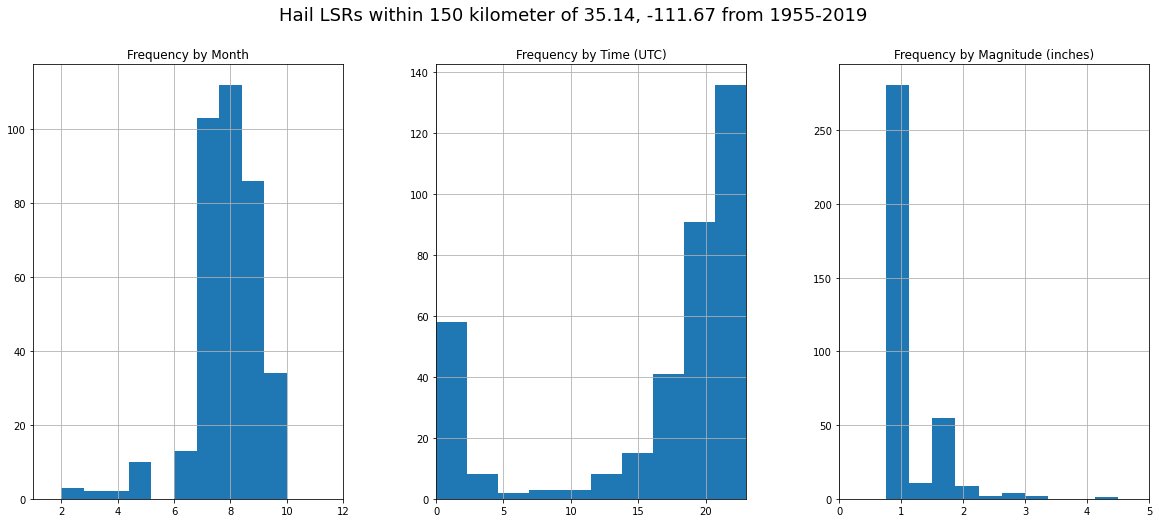

In [12]:
# Create plot for Hail LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

hail_local.hist('mo', ax=ax0)
hail_local.hist('time', ax=ax1)
hail_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax1.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (inches)')
ax2.set_xlim(0, 5)

plt.suptitle(f'Hail LSRs within {max_distance} of {latitude}, {longitude} from 1955-2019', size=18)

plt.show()

In [13]:
# Get local Wind LSR data
wind_local = build_local_db(wind, latitude, longitude, max_distance)
wind_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,210.000000,210.000000,210.000000,210.000000
mean,7.342857,15.080952,11.685714,44.857143
std,1.419809,9.238370,9.996472,22.690313
min,1.000000,1.000000,0.000000,0.000000
25%,7.000000,6.000000,1.000000,50.000000
50%,7.000000,15.000000,13.000000,52.000000
75%,8.000000,24.000000,22.000000,58.000000
max,11.000000,31.000000,23.000000,100.000000


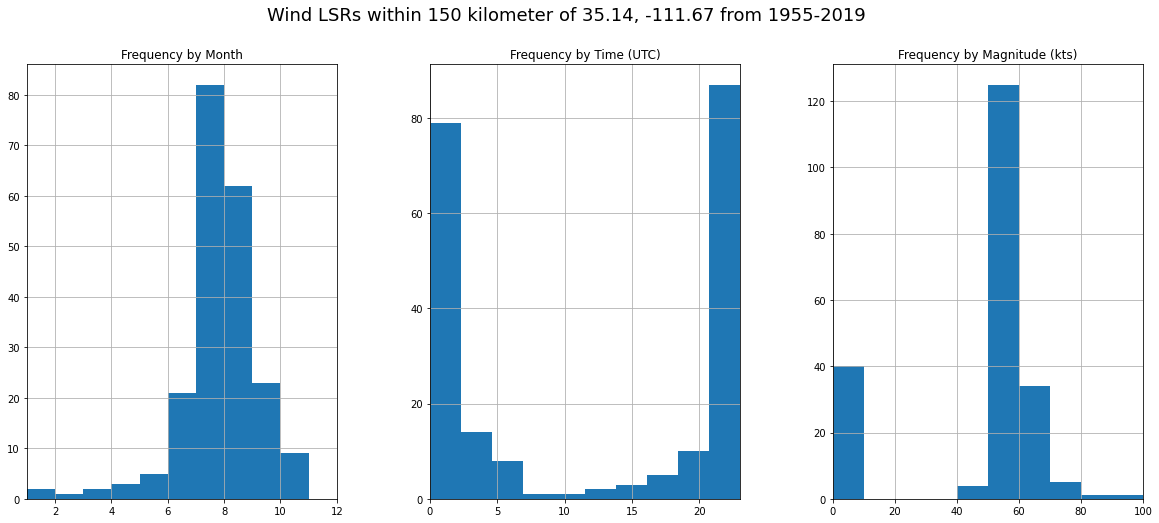

In [14]:
# Create plot for Wind LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

wind_local.hist('mo', ax=ax0)
wind_local.hist('time', ax=ax1)
wind_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax1.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (kts)')
ax2.set_xlim(0, 100)

plt.suptitle(f'Wind LSRs within {max_distance} of {latitude}, {longitude} from 1955-2019', size=18)

plt.show()

In [ ]:
# Get ERA5 reanalysis data for local Tornado LSRs
get_db_reanalysis(tor_local)

2021-04-19 11:53:31,988 INFO Welcome to the CDS
2021-04-19 11:53:31,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2021-04-19 11:53:32,229 INFO Request is completed
2021-04-19 11:53:32,232 INFO Downloading https://download-0013.copernicus-climate.eu/cache-compute-0013/cache/data0/adaptor.mars.internal-1618858176.465884-16226-8-bc75a33a-cb18-4c45-9479-d7d1b28102d8.nc to /home/pi/workspace/Local-Severe-Weather-Stats/data/era5/era5-reanalysis_19930118_2000.nc (27.2M)
2021-04-19 11:53:49,870 INFO Download rate 1.5M/s   
2021-04-19 11:53:50,197 INFO Welcome to the CDS
2021-04-19 11:53:50,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2021-04-19 11:53:50,405 INFO Request is queued


In [ ]:
# Get ERA5 reanalysis data for local Hail LSRs
get_db_reanalysis(hail_local)

In [ ]:
# Get ERA5 reanalysis data for local Wind LSRs
get_db_reanalysis(wind_local)